# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [4]:
train_npz = np.load('cse-251-b-2025/train.npz')
train_data = train_npz['data']
test_npz  = np.load('cse-251-b-2025/test_input.npz')
test_data  = test_npz['data']

In [5]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [6]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [7]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

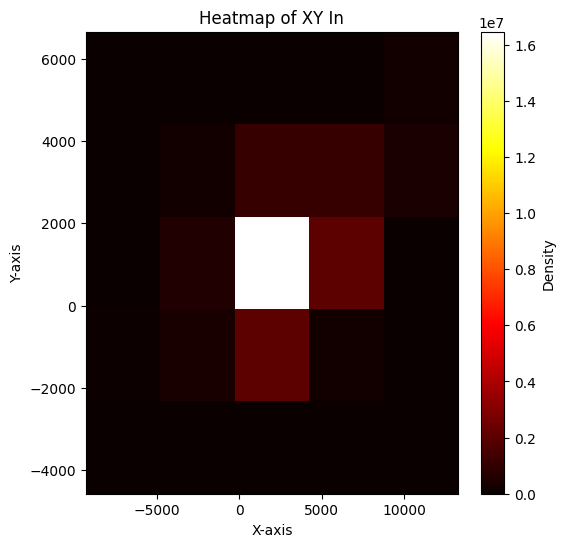

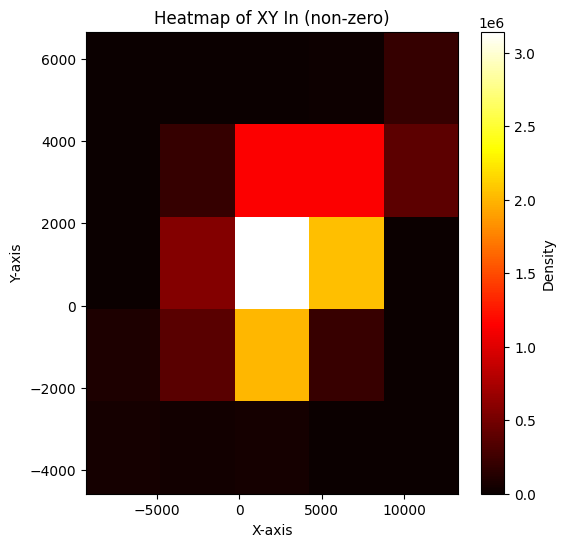

In [8]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

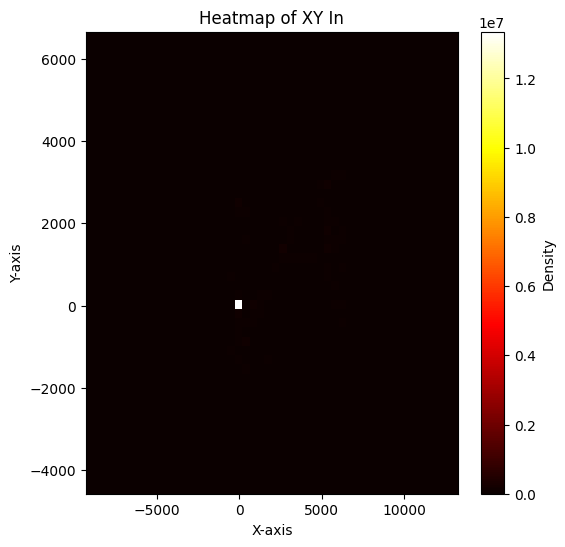

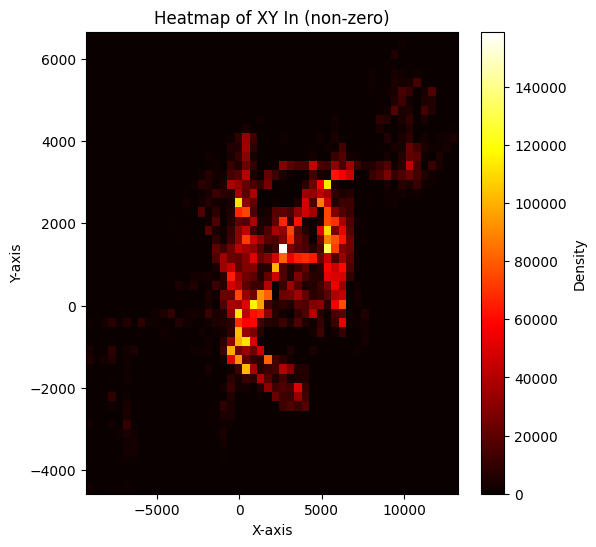

In [9]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [10]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [11]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [12]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [13]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [14]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_out):
        # lstm_out: (B, T, D)
        scores = self.attn(lstm_out).squeeze(-1)  # (B, T)
        weights = torch.softmax(scores, dim=1).unsqueeze(-1)  # (B, T, 1)
        context = torch.sum(weights * lstm_out, dim=1)  # (B, D)
        return context

class LSTMWithRelativeTimeAttention(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=200, output_dim=60 * 2, seq_len=100):
        super(LSTMWithRelativeTimeAttention, self).__init__()
        self.seq_len = seq_len

        # Append 1-dim relative time feature → input_dim + 1
        self.lstm = nn.LSTM(input_dim + 1, hidden_dim, batch_first=True)
        self.attn = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x.view(-1, 50, 50, 6)  # (B, A, T, F)
        x = x[:, 0, :, :]  # Only ego: (B, T, F)

        B, T, F = x.shape

        # Create normalized relative time [0, 1, ..., T-1]/T
        rel_time = torch.linspace(0, 1, T, device=x.device).unsqueeze(0).unsqueeze(-1)  # (1, T, 1)
        rel_time = rel_time.expand(B, -1, -1)  # (B, T, 1)

        x = torch.cat([x, rel_time], dim=-1)  # (B, T, F+1)

        lstm_out, _ = self.lstm(x)  # (B, T, H)
        context = self.attn(lstm_out)  # (B, H)
        out = self.fc(context)  # (B, 120)
        return out.view(-1, 60, 2)  # (B, 60, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [17]:
#model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
model = LSTMWithRelativeTimeAttention().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
early_stopping_patience = 50
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [18]:
for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    scheduler.step()
    # scheduler.step(val_loss)
    
    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

Epoch:   0%|                                                                                | 0/100 [00:00<?, ?epoch/s]C:\Users\dysr3\AppData\Local\Temp\ipykernel_6776\3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
C:\Users\dysr3\AppData\Local\Temp\ipykernel_6776\3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
Epoch:   1%|▋                                                                       | 1/100 [00:02<04:52,  2.96s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.6280 | val normalized MSE   0.8153, | val MAE   3.5540 | val MSE  39.9490


Epoch:   2%|█▍                                                                      | 2/100 [00:05<04:45,  2.91s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.7213 | val normalized MSE   0.6332, | val MAE   3.1651 | val MSE  31.0246


Epoch:   3%|██▏                                                                     | 3/100 [00:08<04:41,  2.90s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.5670 | val normalized MSE   0.6762, | val MAE   3.3459 | val MSE  33.1323


Epoch:   4%|██▉                                                                     | 4/100 [00:11<04:40,  2.92s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.4928 | val normalized MSE   0.4676, | val MAE   2.7479 | val MSE  22.9143


Epoch:   5%|███▌                                                                    | 5/100 [00:14<04:39,  2.94s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.4475 | val normalized MSE   0.4248, | val MAE   2.4630 | val MSE  20.8144


Epoch:   6%|████▎                                                                   | 6/100 [00:17<04:37,  2.95s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.4083 | val normalized MSE   0.3725, | val MAE   2.3796 | val MSE  18.2509


Epoch:   7%|█████                                                                   | 7/100 [00:20<04:34,  2.95s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.3819 | val normalized MSE   0.3775, | val MAE   2.2875 | val MSE  18.4998


Epoch:   8%|█████▊                                                                  | 8/100 [00:23<04:32,  2.97s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.3828 | val normalized MSE   0.3484, | val MAE   2.1285 | val MSE  17.0731


Epoch:   9%|██████▍                                                                 | 9/100 [00:26<04:29,  2.96s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.3555 | val normalized MSE   0.3369, | val MAE   2.1947 | val MSE  16.5090


Epoch:  10%|███████                                                                | 10/100 [00:29<04:26,  2.97s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.3504 | val normalized MSE   0.3410, | val MAE   2.2163 | val MSE  16.7089


Epoch:  11%|███████▊                                                               | 11/100 [00:32<04:24,  2.98s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.3438 | val normalized MSE   0.2836, | val MAE   1.9095 | val MSE  13.8982


Epoch:  12%|████████▌                                                              | 12/100 [00:35<04:22,  2.98s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.3319 | val normalized MSE   0.2974, | val MAE   2.0032 | val MSE  14.5733


Epoch:  13%|█████████▏                                                             | 13/100 [00:38<04:19,  2.99s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.3282 | val normalized MSE   0.3022, | val MAE   1.9388 | val MSE  14.8060


Epoch:  14%|█████████▉                                                             | 14/100 [00:41<04:17,  2.99s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.3106 | val normalized MSE   0.2794, | val MAE   1.9074 | val MSE  13.6893


Epoch:  15%|██████████▋                                                            | 15/100 [00:44<04:14,  3.00s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.3023 | val normalized MSE   0.2872, | val MAE   2.0221 | val MSE  14.0741


Epoch:  16%|███████████▎                                                           | 16/100 [00:47<04:11,  3.00s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.3006 | val normalized MSE   0.2588, | val MAE   1.8562 | val MSE  12.6819


Epoch:  17%|████████████                                                           | 17/100 [00:50<04:08,  3.00s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2892 | val normalized MSE   0.2754, | val MAE   1.9349 | val MSE  13.4948


Epoch:  18%|████████████▊                                                          | 18/100 [00:53<04:05,  3.00s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2888 | val normalized MSE   0.2695, | val MAE   1.9442 | val MSE  13.2060


Epoch:  19%|█████████████▍                                                         | 19/100 [00:56<04:02,  2.99s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2852 | val normalized MSE   0.2675, | val MAE   1.8873 | val MSE  13.1094


Epoch:  20%|██████████████▏                                                        | 20/100 [00:59<03:58,  2.98s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2774 | val normalized MSE   0.2571, | val MAE   1.8197 | val MSE  12.5962


Epoch:  21%|██████████████▉                                                        | 21/100 [01:02<03:55,  2.98s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2382 | val normalized MSE   0.2199, | val MAE   1.5667 | val MSE  10.7740


Epoch:  22%|███████████████▌                                                       | 22/100 [01:05<03:52,  2.98s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.2269 | val normalized MSE   0.2102, | val MAE   1.5621 | val MSE  10.2992


Epoch:  23%|████████████████▎                                                      | 23/100 [01:08<03:50,  2.99s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.2264 | val normalized MSE   0.2096, | val MAE   1.5379 | val MSE  10.2716


Epoch:  24%|█████████████████                                                      | 24/100 [01:11<03:47,  2.99s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.2250 | val normalized MSE   0.2129, | val MAE   1.6228 | val MSE  10.4331


Epoch:  25%|█████████████████▊                                                     | 25/100 [01:14<03:44,  2.99s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.2228 | val normalized MSE   0.2002, | val MAE   1.4965 | val MSE   9.8120


Epoch:  26%|██████████████████▍                                                    | 26/100 [01:17<03:41,  3.00s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.2232 | val normalized MSE   0.2036, | val MAE   1.5196 | val MSE   9.9749


Epoch:  27%|███████████████████▏                                                   | 27/100 [01:20<03:39,  3.00s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.2187 | val normalized MSE   0.2065, | val MAE   1.5545 | val MSE  10.1182


Epoch:  28%|███████████████████▉                                                   | 28/100 [01:23<03:35,  3.00s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.2182 | val normalized MSE   0.2115, | val MAE   1.6314 | val MSE  10.3614


Epoch:  29%|████████████████████▌                                                  | 29/100 [01:26<03:32,  2.99s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.2192 | val normalized MSE   0.2016, | val MAE   1.5453 | val MSE   9.8808


Epoch:  30%|█████████████████████▎                                                 | 30/100 [01:29<03:28,  2.98s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.2163 | val normalized MSE   0.2077, | val MAE   1.5508 | val MSE  10.1751


Epoch:  31%|██████████████████████                                                 | 31/100 [01:32<03:25,  2.98s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.2141 | val normalized MSE   0.2181, | val MAE   1.6583 | val MSE  10.6855


Epoch:  32%|██████████████████████▋                                                | 32/100 [01:35<03:22,  2.98s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.2156 | val normalized MSE   0.2041, | val MAE   1.5426 | val MSE  10.0011


Epoch:  33%|███████████████████████▍                                               | 33/100 [01:38<03:20,  2.99s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.2138 | val normalized MSE   0.1978, | val MAE   1.4824 | val MSE   9.6898


Epoch:  34%|████████████████████████▏                                              | 34/100 [01:41<03:17,  2.99s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.2164 | val normalized MSE   0.2100, | val MAE   1.6275 | val MSE  10.2891


Epoch:  35%|████████████████████████▊                                              | 35/100 [01:44<03:14,  2.99s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.2129 | val normalized MSE   0.1985, | val MAE   1.5226 | val MSE   9.7254


Epoch:  36%|█████████████████████████▌                                             | 36/100 [01:47<03:11,  2.99s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.2107 | val normalized MSE   0.2059, | val MAE   1.5497 | val MSE  10.0868


Epoch:  37%|██████████████████████████▎                                            | 37/100 [01:50<03:08,  3.00s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.2109 | val normalized MSE   0.1933, | val MAE   1.4861 | val MSE   9.4736


Epoch:  38%|██████████████████████████▉                                            | 38/100 [01:53<03:05,  3.00s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.2108 | val normalized MSE   0.1990, | val MAE   1.4816 | val MSE   9.7500


Epoch:  39%|███████████████████████████▋                                           | 39/100 [01:56<03:02,  3.00s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.2080 | val normalized MSE   0.1953, | val MAE   1.4914 | val MSE   9.5718


Epoch:  40%|████████████████████████████▍                                          | 40/100 [01:59<02:59,  2.99s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.2085 | val normalized MSE   0.1969, | val MAE   1.5238 | val MSE   9.6463


Epoch:  41%|█████████████████████████████                                          | 41/100 [02:02<02:56,  2.99s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1984 | val normalized MSE   0.1909, | val MAE   1.4614 | val MSE   9.3535


Epoch:  42%|█████████████████████████████▊                                         | 42/100 [02:05<02:53,  2.98s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1951 | val normalized MSE   0.1921, | val MAE   1.4455 | val MSE   9.4136


Epoch:  43%|██████████████████████████████▌                                        | 43/100 [02:08<02:50,  2.99s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1934 | val normalized MSE   0.1864, | val MAE   1.4302 | val MSE   9.1337


Epoch:  44%|███████████████████████████████▏                                       | 44/100 [02:11<02:47,  3.00s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1922 | val normalized MSE   0.1884, | val MAE   1.4433 | val MSE   9.2331


Epoch:  45%|███████████████████████████████▉                                       | 45/100 [02:14<02:45,  3.00s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1931 | val normalized MSE   0.1889, | val MAE   1.4488 | val MSE   9.2545


Epoch:  46%|████████████████████████████████▋                                      | 46/100 [02:17<02:41,  3.00s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1914 | val normalized MSE   0.1849, | val MAE   1.4089 | val MSE   9.0622


Epoch:  47%|█████████████████████████████████▎                                     | 47/100 [02:20<02:38,  3.00s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1906 | val normalized MSE   0.1842, | val MAE   1.4042 | val MSE   9.0253


Epoch:  48%|██████████████████████████████████                                     | 48/100 [02:23<02:35,  3.00s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1915 | val normalized MSE   0.1877, | val MAE   1.4359 | val MSE   9.1992


Epoch:  49%|██████████████████████████████████▊                                    | 49/100 [02:26<02:32,  3.00s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1902 | val normalized MSE   0.1905, | val MAE   1.4592 | val MSE   9.3350


Epoch:  50%|███████████████████████████████████▌                                   | 50/100 [02:29<02:29,  2.99s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1909 | val normalized MSE   0.1854, | val MAE   1.4057 | val MSE   9.0865


Epoch:  51%|████████████████████████████████████▏                                  | 51/100 [02:32<02:26,  2.99s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1907 | val normalized MSE   0.1835, | val MAE   1.4077 | val MSE   8.9938


Epoch:  52%|████████████████████████████████████▉                                  | 52/100 [02:35<02:23,  2.99s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1906 | val normalized MSE   0.1866, | val MAE   1.4528 | val MSE   9.1446


Epoch:  53%|█████████████████████████████████████▋                                 | 53/100 [02:38<02:20,  2.99s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1893 | val normalized MSE   0.1850, | val MAE   1.4245 | val MSE   9.0645


Epoch:  54%|██████████████████████████████████████▎                                | 54/100 [02:41<02:17,  2.99s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1895 | val normalized MSE   0.1845, | val MAE   1.4469 | val MSE   9.0384


Epoch:  55%|███████████████████████████████████████                                | 55/100 [02:44<02:14,  2.99s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1895 | val normalized MSE   0.1847, | val MAE   1.4101 | val MSE   9.0514


Epoch:  56%|███████████████████████████████████████▊                               | 56/100 [02:47<02:11,  2.99s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1880 | val normalized MSE   0.1819, | val MAE   1.4063 | val MSE   8.9117


Epoch:  57%|████████████████████████████████████████▍                              | 57/100 [02:50<02:08,  2.99s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1883 | val normalized MSE   0.1836, | val MAE   1.4328 | val MSE   8.9960


Epoch:  58%|█████████████████████████████████████████▏                             | 58/100 [02:53<02:05,  2.99s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1880 | val normalized MSE   0.1890, | val MAE   1.4694 | val MSE   9.2596


Epoch:  59%|█████████████████████████████████████████▉                             | 59/100 [02:56<02:02,  2.99s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1882 | val normalized MSE   0.1811, | val MAE   1.4015 | val MSE   8.8751


Epoch:  60%|██████████████████████████████████████████▌                            | 60/100 [02:59<01:59,  2.99s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1887 | val normalized MSE   0.1885, | val MAE   1.4623 | val MSE   9.2373


Epoch:  61%|███████████████████████████████████████████▎                           | 61/100 [03:02<01:56,  2.99s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1857 | val normalized MSE   0.1827, | val MAE   1.3915 | val MSE   8.9516


Epoch:  62%|████████████████████████████████████████████                           | 62/100 [03:05<01:53,  2.98s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1835 | val normalized MSE   0.1839, | val MAE   1.4139 | val MSE   9.0129


Epoch:  63%|████████████████████████████████████████████▋                          | 63/100 [03:08<01:50,  2.98s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1828 | val normalized MSE   0.1837, | val MAE   1.4066 | val MSE   9.0037


Epoch:  64%|█████████████████████████████████████████████▍                         | 64/100 [03:11<01:47,  2.98s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1822 | val normalized MSE   0.1832, | val MAE   1.3933 | val MSE   8.9746


Epoch:  65%|██████████████████████████████████████████████▏                        | 65/100 [03:14<01:44,  2.98s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1818 | val normalized MSE   0.1825, | val MAE   1.3930 | val MSE   8.9410


Epoch:  66%|██████████████████████████████████████████████▊                        | 66/100 [03:16<01:41,  2.99s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1818 | val normalized MSE   0.1808, | val MAE   1.3864 | val MSE   8.8570


Epoch:  67%|███████████████████████████████████████████████▌                       | 67/100 [03:19<01:38,  2.99s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1826 | val normalized MSE   0.1832, | val MAE   1.4019 | val MSE   8.9760


Epoch:  68%|████████████████████████████████████████████████▎                      | 68/100 [03:22<01:35,  2.99s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1814 | val normalized MSE   0.1836, | val MAE   1.4009 | val MSE   8.9967


Epoch:  69%|████████████████████████████████████████████████▉                      | 69/100 [03:25<01:32,  2.99s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1821 | val normalized MSE   0.1828, | val MAE   1.3891 | val MSE   8.9586


Epoch:  70%|█████████████████████████████████████████████████▋                     | 70/100 [03:28<01:29,  3.00s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1819 | val normalized MSE   0.1824, | val MAE   1.4112 | val MSE   8.9377


Epoch:  71%|██████████████████████████████████████████████████▍                    | 71/100 [03:31<01:26,  3.00s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1817 | val normalized MSE   0.1822, | val MAE   1.3768 | val MSE   8.9291


Epoch:  72%|███████████████████████████████████████████████████                    | 72/100 [03:34<01:23,  2.98s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1812 | val normalized MSE   0.1812, | val MAE   1.3784 | val MSE   8.8808


Epoch:  73%|███████████████████████████████████████████████████▊                   | 73/100 [03:37<01:20,  2.98s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1817 | val normalized MSE   0.1827, | val MAE   1.3953 | val MSE   8.9536


Epoch:  74%|████████████████████████████████████████████████████▌                  | 74/100 [03:40<01:17,  2.98s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1818 | val normalized MSE   0.1839, | val MAE   1.3952 | val MSE   9.0087


Epoch:  75%|█████████████████████████████████████████████████████▎                 | 75/100 [03:43<01:14,  2.98s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1808 | val normalized MSE   0.1820, | val MAE   1.3855 | val MSE   8.9175


Epoch:  76%|█████████████████████████████████████████████████████▉                 | 76/100 [03:46<01:11,  2.98s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1807 | val normalized MSE   0.1831, | val MAE   1.3920 | val MSE   8.9695


Epoch:  77%|██████████████████████████████████████████████████████▋                | 77/100 [03:49<01:08,  2.98s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1819 | val normalized MSE   0.1813, | val MAE   1.3870 | val MSE   8.8834


Epoch:  78%|███████████████████████████████████████████████████████▍               | 78/100 [03:52<01:05,  2.98s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1825 | val normalized MSE   0.1822, | val MAE   1.3911 | val MSE   8.9275


Epoch:  79%|████████████████████████████████████████████████████████               | 79/100 [03:55<01:02,  2.96s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1822 | val normalized MSE   0.1841, | val MAE   1.4077 | val MSE   9.0226


Epoch:  80%|████████████████████████████████████████████████████████▊              | 80/100 [03:58<00:58,  2.95s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1812 | val normalized MSE   0.1809, | val MAE   1.3934 | val MSE   8.8636


Epoch:  81%|█████████████████████████████████████████████████████████▌             | 81/100 [04:01<00:56,  2.95s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1793 | val normalized MSE   0.1813, | val MAE   1.3798 | val MSE   8.8845


Epoch:  82%|██████████████████████████████████████████████████████████▏            | 82/100 [04:04<00:53,  2.96s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1801 | val normalized MSE   0.1817, | val MAE   1.3808 | val MSE   8.9036


Epoch:  83%|██████████████████████████████████████████████████████████▉            | 83/100 [04:07<00:50,  2.97s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1801 | val normalized MSE   0.1812, | val MAE   1.3796 | val MSE   8.8765


Epoch:  84%|███████████████████████████████████████████████████████████▋           | 84/100 [04:10<00:47,  2.98s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1795 | val normalized MSE   0.1816, | val MAE   1.3904 | val MSE   8.8989


Epoch:  85%|████████████████████████████████████████████████████████████▎          | 85/100 [04:13<00:44,  2.97s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1797 | val normalized MSE   0.1816, | val MAE   1.3791 | val MSE   8.9006


Epoch:  86%|█████████████████████████████████████████████████████████████          | 86/100 [04:16<00:41,  2.97s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1791 | val normalized MSE   0.1817, | val MAE   1.3793 | val MSE   8.9039


Epoch:  87%|█████████████████████████████████████████████████████████████▊         | 87/100 [04:19<00:38,  2.97s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1799 | val normalized MSE   0.1820, | val MAE   1.3828 | val MSE   8.9204


Epoch:  88%|██████████████████████████████████████████████████████████████▍        | 88/100 [04:22<00:35,  2.98s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1790 | val normalized MSE   0.1817, | val MAE   1.3835 | val MSE   8.9022


Epoch:  89%|███████████████████████████████████████████████████████████████▏       | 89/100 [04:25<00:32,  2.98s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1800 | val normalized MSE   0.1816, | val MAE   1.3761 | val MSE   8.8977


Epoch:  90%|███████████████████████████████████████████████████████████████▉       | 90/100 [04:28<00:29,  2.97s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1791 | val normalized MSE   0.1822, | val MAE   1.3824 | val MSE   8.9274


Epoch:  91%|████████████████████████████████████████████████████████████████▌      | 91/100 [04:31<00:26,  2.97s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1793 | val normalized MSE   0.1818, | val MAE   1.3796 | val MSE   8.9077


Epoch:  92%|█████████████████████████████████████████████████████████████████▎     | 92/100 [04:34<00:23,  2.97s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1790 | val normalized MSE   0.1820, | val MAE   1.3764 | val MSE   8.9185


Epoch:  93%|██████████████████████████████████████████████████████████████████     | 93/100 [04:37<00:20,  2.97s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1792 | val normalized MSE   0.1822, | val MAE   1.3810 | val MSE   8.9260


Epoch:  94%|██████████████████████████████████████████████████████████████████▋    | 94/100 [04:40<00:17,  2.97s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1799 | val normalized MSE   0.1812, | val MAE   1.3708 | val MSE   8.8803


Epoch:  95%|███████████████████████████████████████████████████████████████████▍   | 95/100 [04:43<00:14,  2.97s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1805 | val normalized MSE   0.1815, | val MAE   1.3788 | val MSE   8.8946


Epoch:  96%|████████████████████████████████████████████████████████████████████▏  | 96/100 [04:46<00:11,  2.98s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1793 | val normalized MSE   0.1812, | val MAE   1.3755 | val MSE   8.8784


Epoch:  97%|████████████████████████████████████████████████████████████████████▊  | 97/100 [04:49<00:08,  2.98s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1792 | val normalized MSE   0.1807, | val MAE   1.3709 | val MSE   8.8561


Epoch:  98%|█████████████████████████████████████████████████████████████████████▌ | 98/100 [04:52<00:05,  2.97s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1795 | val normalized MSE   0.1813, | val MAE   1.3754 | val MSE   8.8838


Epoch:  99%|██████████████████████████████████████████████████████████████████████▎| 99/100 [04:55<00:02,  2.97s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.1811 | val normalized MSE   0.1809, | val MAE   1.3756 | val MSE   8.8646


Epoch: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [04:58<00:00,  2.98s/epoch]

Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.1792 | val normalized MSE   0.1808, | val MAE   1.3744 | val MSE   8.8604


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [22]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

C:\Users\dysr3\AppData\Local\Temp\ipykernel_6776\3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin


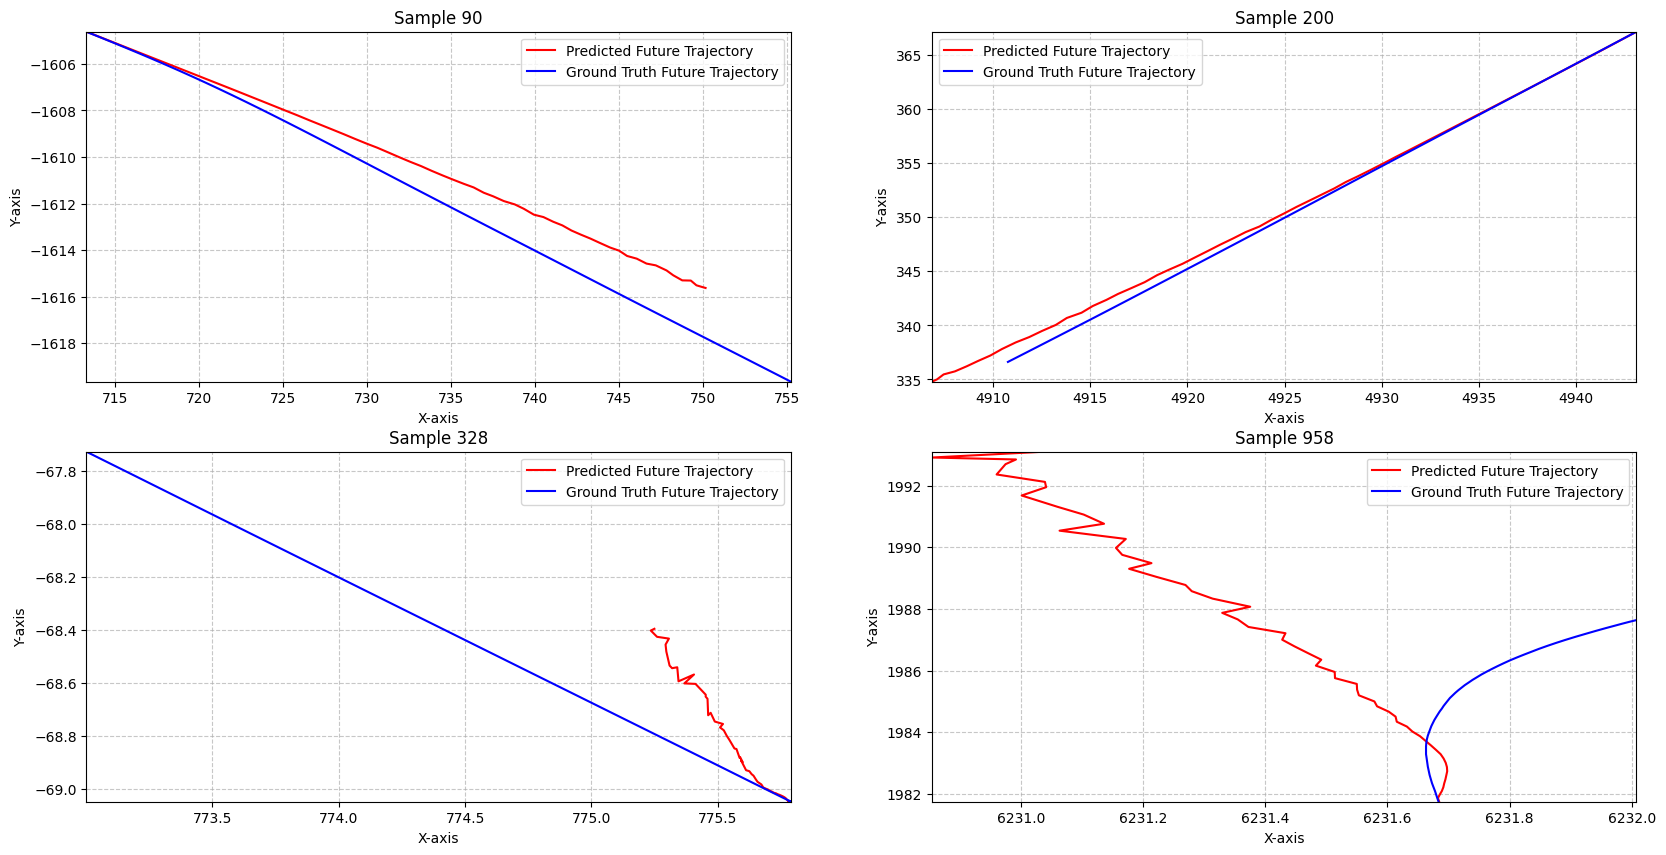

In [23]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [24]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
#model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
model = LSTMWithRelativeTimeAttention().to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B